# Implicit likelihood inference: Gaussian signals exercise

Florent Leclercq,<br/>
Institut d'Astrophysique de Paris,<br/>
florent.leclercq@iap.fr

In [1]:
import numpy as np
import scipy
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
np.random.seed(1)

In [2]:
# Plotting utilities
colorsDict = {
                  # Match pygtc up to v0.2.4
                  'blues_old' : ('#4c72b0','#7fa5e3','#b2d8ff'),
                  'greens_old' : ('#55a868','#88db9b','#bbffce'),
                  'yellows_old' : ('#f5964f','#ffc982','#fffcb5'),
                  'reds_old' : ('#c44e52','#f78185','#ffb4b8'),
                  'purples_old' : ('#8172b2','#b4a5e5','#37d8ff'),
                  # New color scheme, dark colors match matplotlib v2
                  'blues' : ('#1f77b4','#52aae7','#85ddff'),
                  'oranges' : ('#ff7f0e','#ffb241','#ffe574'),
                  'greens' : ('#2ca02c','#5fd35f','#92ff92'),
                  'reds' : ('#d62728','#ff5a5b','#ff8d8e'),
                  'purples' : ('#9467bd','#c79af0','#facdff'),
                  'browns' : ('#8c564b','#bf897e','#f2bcb1'),
                  'pinks' : ('#e377c2','#ffaaf5','#ffddff'),
                  'grays' : ('#7f7f7f','#b2b2b2','#e5e5e5'),
                  'yellows' : ('#bcbd22','#eff055','#ffff88'),
                  'cyans' : ('#17becf','#4af1ff','#7dffff'),
              }
defaultColorsOrder = ['blues', 'oranges','greens', 'reds', 'purples',
                        'browns', 'pinks', 'grays', 'yellows', 'cyans']
colors = [colorsDict[cs] for cs in defaultColorsOrder]

def get_contours(Z, nBins, confLevels=(.3173, .0455, .0027)):
    Z /= Z.sum()
    nContourLevels = len(confLevels)
    chainLevels = np.ones(nContourLevels+1)
    histOrdered = np.sort(Z.flat)
    histCumulative = np.cumsum(histOrdered)
    nBinsFlat = np.linspace(0., nBins**2, nBins**2)

    for l in range(nContourLevels):
        # Find location of contour level in 1d histCumulative
        temp = np.interp(confLevels[l], histCumulative, nBinsFlat)
        # Find "height" of contour level
        chainLevels[nContourLevels-1-l] = np.interp(temp, nBinsFlat, histOrdered)

    return chainLevels

nContourLevels = 3

## Simulate data

In [3]:
mu_true = 0.8
sigma_sq_true = 2.9
n = 50
d_obs = np.random.normal(mu_true, np.sqrt(sigma_sq_true), n)

##  Analytic solution

In [4]:
def sprior_pdf(mu, sigma_sq, eta, lambda_, alpha, beta):
    from math import sqrt
    if sigma_sq>0:
        return ss.invgamma(alpha, 0, scale=beta).pdf(sigma_sq)*ss.norm(eta, sqrt(sigma_sq/lambda_)).pdf(mu)
    else:
        raise ValueError("sigma_sq should be non-negative")
vprior_pdf = np.vectorize(sprior_pdf)
vprior_pdf.excluded.add(2)
vprior_pdf.excluded.add(3)
vprior_pdf.excluded.add(4)
vprior_pdf.excluded.add(5)

In [6]:
def prior_hyperparameters_to_posterior_hyperparameters(eta, lambda_, alpha, beta, d_obs, n):
    Phi1_obs = np.mean(d_obs)
    Phi2_obs = np.var(d_obs, ddof=1)
    alpha_p = alpha + n/2
    beta_p = beta + n*lambda_/(lambda_+ n) * (Phi1_obs - eta)**2/2 + (n-1)/2 * Phi2_obs
    eta_p = (lambda_*eta + n*Phi1_obs)/(lambda_ + n)
    lambda_p = lambda_ + n
    return eta_p, lambda_p, alpha_p, beta_p

In [7]:
eta, lambda_, alpha, beta = 0, 6, 22, 54
eta_post, lambda_post, alpha_post, beta_post = prior_hyperparameters_to_posterior_hyperparameters(eta, lambda_, alpha, beta, d_obs, n)

In [9]:
meshsize = 100
bounds = {'mu': (-3, 3), 'sigma_sq': (1, 5.5)}

mu_s = np.linspace(bounds['mu'][0],bounds['mu'][1],meshsize)
sigma_sq_s = np.linspace(bounds['sigma_sq'][0],bounds['sigma_sq'][1],meshsize)
mu_g, sigma_sq_g = np.meshgrid(mu_s,sigma_sq_s)
prior_g = vprior_pdf(mu_g, sigma_sq_g, eta, lambda_, alpha, beta)
prior_g /= prior_g.sum()
prior_contours = get_contours(prior_g, meshsize)

posterior_g = vprior_pdf(mu_g, sigma_sq_g, eta_post, lambda_post, alpha_post, beta_post)
posterior_g /= posterior_g.sum()
posterior_contours = get_contours(posterior_g, meshsize)

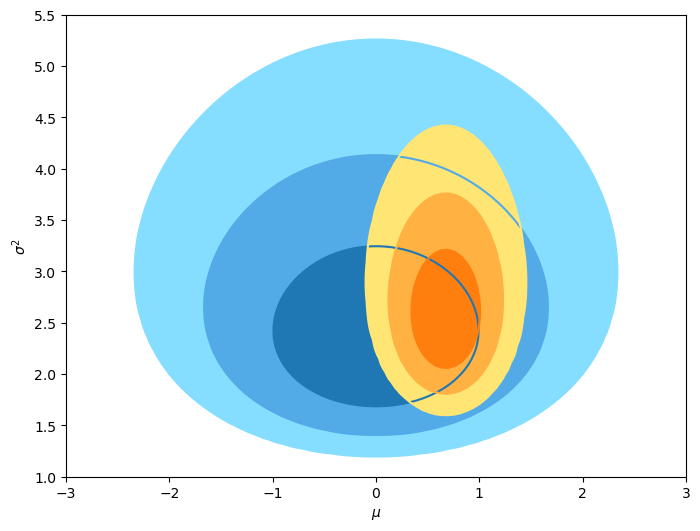

In [10]:
plt.figure(figsize=(8,6))
plt.xlim(bounds['mu'])
plt.xlabel("$\mu$")
plt.ylim(bounds['sigma_sq'])
plt.ylabel("$\sigma^2$")
plt.contourf(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])
plt.contour(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])

plt.contourf(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
plt.contour(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])

## Run simulations

In [11]:
def simulator(mu, sigma_sq, N):
    mu, sigma_sq = np.atleast_1d(mu, sigma_sq)
    sigma = np.sqrt(sigma_sq)
    return ss.norm.rvs(mu[:, None, None], sigma[:, None, None], size=(N, n))

def compressor(y):
    return np.array([np.mean(y, axis=1), np.var(y, axis=1, ddof=1)])

Phi_obs = np.array([np.mean(d_obs), np.var(d_obs, ddof=1)])

In [12]:
sims = compressor(simulator(mu_true, sigma_sq_true, 10000))

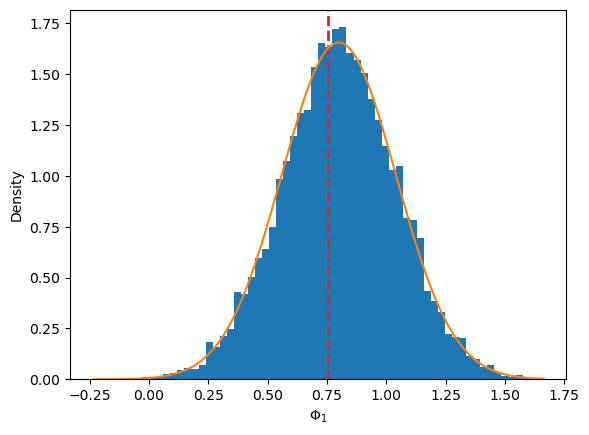

In [13]:
# Phi1 is Gaussian distributed with mean mu and variance sigma_sq/n
Phi1=sims[0]
hist, bins, patches = plt.hist(Phi1, bins='auto', density=True)
x = np.linspace(bins.min(), bins.max(),200)
plt.axvline(Phi_obs[0], color='C3', linestyle='--', lw=2)
plt.xlabel("$\Phi_1$")
plt.ylabel("Density")
plt.plot(x, ss.norm(mu_true, np.sqrt(sigma_sq_true/n)).pdf(x))

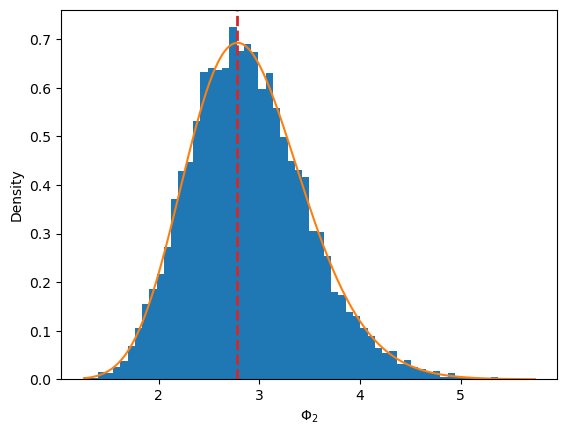

In [14]:
# Phi2 is Gamma distributed with shape k=(n-1)/2 and scale theta=2*sigma_sq/(n-1)
Phi2=sims[1]
hist, bins, patches = plt.hist(Phi2, bins='auto', density=True)
x = np.linspace(bins.min(), bins.max(),200)
plt.axvline(Phi_obs[1], color='C3', linestyle='--', lw=2)
plt.xlabel("$\Phi_2$")
plt.ylabel("Density")
plt.plot(x, ss.gamma((n-1.)/2., scale=2*sigma_sq_true/(n-1.)).pdf(x))

Text(0, 0.5, '$\\Phi_2$')

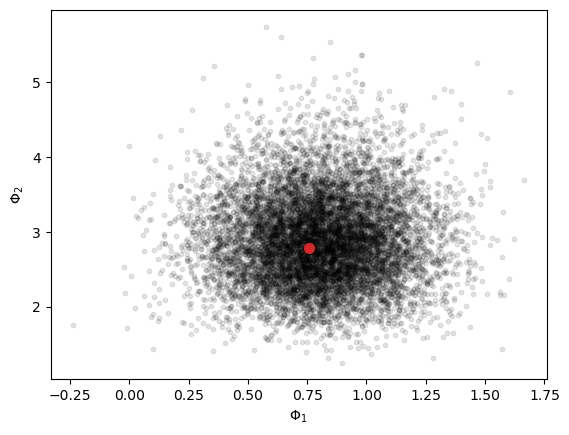

In [15]:
plt.scatter(sims[0], sims[1], s=10, alpha=0.1, color='black')
plt.scatter(Phi_obs[0], Phi_obs[1], color='C3', lw=2)
plt.xlabel(r"$\Phi_1$")
plt.ylabel(r"$\Phi_2$")

## Implicit likelihood inference

In [16]:
N=10

In [17]:
def approximate_bayesian_computation(Phi_obs, epsilon, nsamples, N, eta, lambda_, alpha, beta):
    from math import sqrt
    accepted_samples = []
    distances = []

    # Loop over the number of simulations.
    while(len(accepted_samples) < nsamples):
        # --- Sample candidate parameters from the prior ---
        sigma_sq_candidate = ss.invgamma(alpha, 0, scale=beta).rvs()
        mu_candidate = ss.norm(eta, sqrt(sigma_sq_candidate/lambda_)).rvs()

        # --- Simulation Step ---
        # We simulate one dataset for the current candidate.
        # simulator expects array inputs; here we create arrays of length 1.
        sim_data = simulator(np.array([mu_candidate]),
                             np.array([sigma_sq_candidate]),
                             N)

        # --- Compression Step ---
        # Compute the summary statistics of the simulation.
        Phi_sim = compressor(sim_data)[:, 0]  # compressor returns an array with shape (2, 1)

        # --- Distance Calculation ---
        # Compute Euclidean distance between simulated and observed summaries.
        distance = np.linalg.norm(Phi_sim - Phi_obs)

        # --- Acceptance Step ---
        if distance < epsilon:
            accepted_samples.append([mu_candidate, sigma_sq_candidate])
            distances.append(distance)

    return np.array(accepted_samples), distances

In [27]:
epsilon = 1.
rejection_samples_eps1, distances_eps1 = approximate_bayesian_computation(Phi_obs, epsilon, 4000, N, eta, lambda_, alpha, beta)
epsilon = 0.5
rejection_samples_eps05, distances_eps05 = approximate_bayesian_computation(Phi_obs, epsilon, 4000, N, eta, lambda_, alpha, beta)
epsilon = 0.3
rejection_samples_eps03, distances_eps03 = approximate_bayesian_computation(Phi_obs, epsilon, 4000, N, eta, lambda_, alpha, beta)

In [30]:
np.savez('ABC_rejection_samples.npz',
         rejection_samples_eps1=rejection_samples_eps1,
         rejection_samples_eps05=rejection_samples_eps05,
         rejection_samples_eps03=rejection_samples_eps03,
         distances_eps1=distances_eps1,
         distances_eps05=distances_eps05,
         distances_eps03=distances_eps03)

In [18]:
rejection_samples_eps1 = np.load('ABC_rejection_samples.npz')['rejection_samples_eps1']
rejection_samples_eps05 = np.load('ABC_rejection_samples.npz')['rejection_samples_eps05']
rejection_samples_eps03 = np.load('ABC_rejection_samples.npz')['rejection_samples_eps03']
distances_eps1 = np.load('ABC_rejection_samples.npz')['distances_eps1']
distances_eps05 = np.load('ABC_rejection_samples.npz')['distances_eps05']
distances_eps03 = np.load('ABC_rejection_samples.npz')['distances_eps03']

In [19]:
nBins=30
rejection_eps1_g, xedges, yedges = np.histogram2d(rejection_samples_eps1.T[1], rejection_samples_eps1.T[0], bins=nBins, range=[[bounds['sigma_sq'][0],bounds['sigma_sq'][1]] ,[bounds['mu'][0],bounds['mu'][1]]])
rejection_eps1_g /= rejection_eps1_g.sum()
rejection_eps1_g = scipy.ndimage.gaussian_filter(rejection_eps1_g, sigma=1)
rejection_eps1_contours = get_contours(rejection_eps1_g, nBins)

rejection_eps05_g, xedges, yedges = np.histogram2d(rejection_samples_eps05.T[1], rejection_samples_eps05.T[0], bins=nBins, range=[[bounds['sigma_sq'][0],bounds['sigma_sq'][1]] ,[bounds['mu'][0],bounds['mu'][1]]])
rejection_eps05_g /= rejection_eps05_g.sum()
rejection_eps05_g = scipy.ndimage.gaussian_filter(rejection_eps05_g, sigma=1)
rejection_eps05_contours = get_contours(rejection_eps05_g, nBins)

rejection_eps03_g, xedges, yedges = np.histogram2d(rejection_samples_eps03.T[1], rejection_samples_eps03.T[0], bins=nBins, range=[[bounds['sigma_sq'][0],bounds['sigma_sq'][1]] ,[bounds['mu'][0],bounds['mu'][1]]])
rejection_eps03_g /= rejection_eps03_g.sum()
rejection_eps03_g = scipy.ndimage.gaussian_filter(rejection_eps03_g, sigma=1)
rejection_eps03_contours = get_contours(rejection_eps03_g, nBins)

mu_s_2 = np.linspace(bounds['mu'][0],bounds['mu'][1],nBins)
sigma_sq_s_2 = np.linspace(bounds['sigma_sq'][0],bounds['sigma_sq'][1],nBins)
mu_g_2, sigma_sq_g_2 = np.meshgrid(mu_s_2,sigma_sq_s_2)

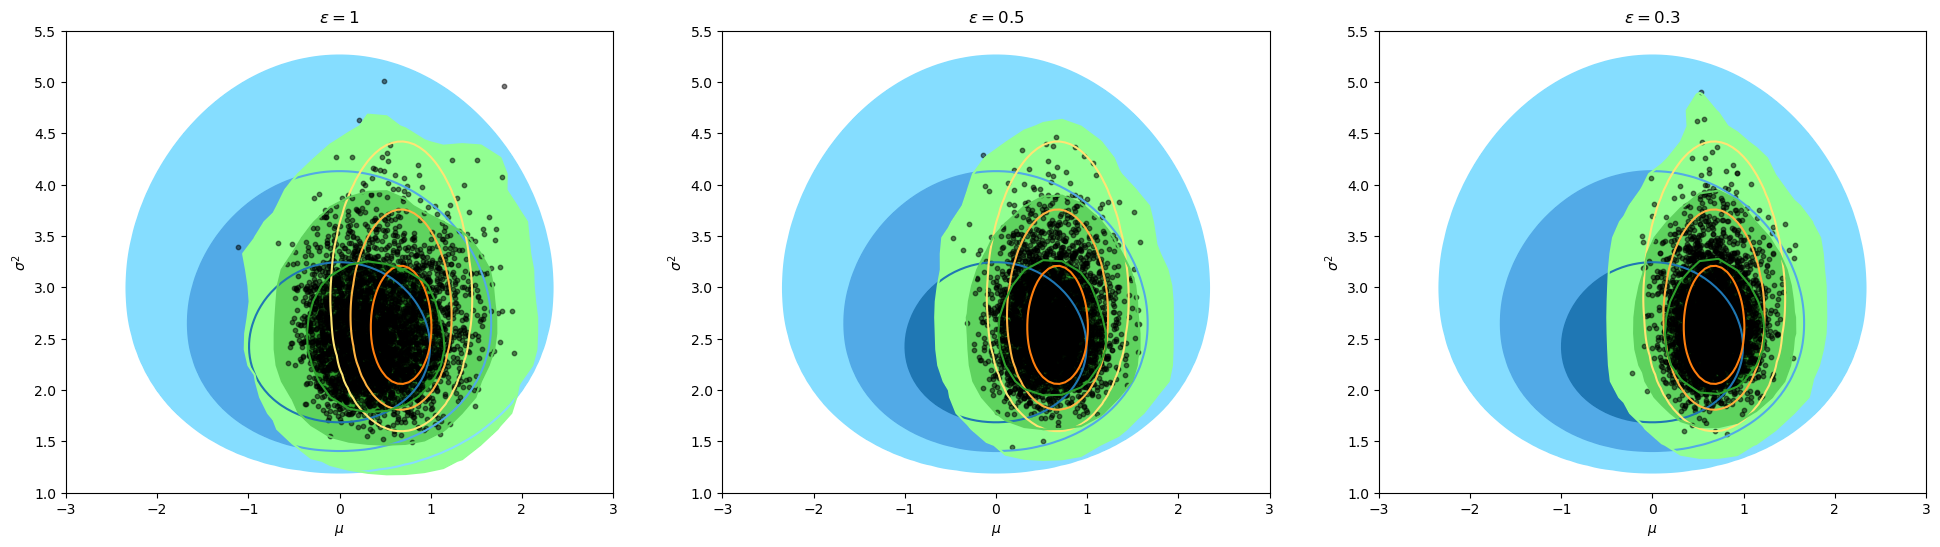

In [20]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(24,6))

ax0.set_xlim(bounds['mu'])
ax0.set_xlabel("$\mu$")
ax0.set_ylim(bounds['sigma_sq'])
ax0.set_ylabel("$\sigma^2$")
ax0.set_title(r"$\epsilon=1$")
ax0.contourf(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])
ax0.contour(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])

ax0.contourf(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
ax0.contour(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
ax0.contour(mu_g_2, sigma_sq_g_2, rejection_eps1_g, levels=rejection_eps1_contours,
                    colors=colors[2][:nContourLevels][::-1])
ax0.contourf(mu_g_2, sigma_sq_g_2, rejection_eps1_g, levels=rejection_eps1_contours,
                    colors=colors[2][:nContourLevels][::-1])
ax0.scatter(rejection_samples_eps1[:, 0], rejection_samples_eps1[:, 1], s=10, alpha=0.5, color='black')

ax1.set_xlim(bounds['mu'])
ax1.set_xlabel("$\mu$")
ax1.set_ylim(bounds['sigma_sq'])
ax1.set_ylabel("$\sigma^2$")
ax1.set_title(r"$\epsilon=0.5$")
ax1.contourf(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])
ax1.contour(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])
ax1.contourf(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
ax1.contour(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
ax1.contour(mu_g_2, sigma_sq_g_2, rejection_eps05_g, levels=rejection_eps05_contours,
                    colors=colors[2][:nContourLevels][::-1])
ax1.contourf(mu_g_2, sigma_sq_g_2, rejection_eps05_g, levels=rejection_eps05_contours,
                    colors=colors[2][:nContourLevels][::-1])

ax1.scatter(rejection_samples_eps05[:, 0], rejection_samples_eps05[:, 1], s=10, alpha=0.5, color='black')

ax2.set_xlim(bounds['mu'])
ax2.set_xlabel("$\mu$")
ax2.set_ylim(bounds['sigma_sq'])
ax2.set_ylabel("$\sigma^2$")
ax2.set_title(r"$\epsilon=0.3$")
ax2.contourf(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])
ax2.contour(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])
ax2.contourf(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
ax2.contour(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
ax2.contour(mu_g_2, sigma_sq_g_2, rejection_eps03_g, levels=rejection_eps03_contours,
                    colors=colors[2][:nContourLevels][::-1])
ax2.contourf(mu_g_2, sigma_sq_g_2, rejection_eps03_g, levels=rejection_eps03_contours,
                    colors=colors[2][:nContourLevels][::-1])
ax2.scatter(rejection_samples_eps03[:, 0], rejection_samples_eps03[:, 1], s=10, alpha=0.5, color='black')

In [31]:
def approximate_bayesian_computation_dropPhi(Phi_obs, epsilon, nsamples, N, eta, lambda_, alpha, beta, drop=False):
    from math import sqrt
    accepted_samples = []
    distances = []

    # Loop over the number of simulations.
    while(len(accepted_samples) < nsamples):
        # --- Sample candidate parameters from the prior ---
        sigma_sq_candidate = ss.invgamma(alpha, 0, scale=beta).rvs()
        mu_candidate = ss.norm(eta, sqrt(sigma_sq_candidate/lambda_)).rvs()

        # --- Simulation Step ---
        # We simulate one dataset for the current candidate.
        # simulator expects array inputs; here we create arrays of length 1.
        sim_data = simulator(np.array([mu_candidate]),
                             np.array([sigma_sq_candidate]),
                             N)

        # --- Compression Step ---
        # Compute the summary statistics of the simulation.
        Phi_sim = compressor(sim_data)[:, 0]  # compressor returns an array with shape (2, 1)

        # --- Drop some part of the information ---
        if drop==1:
            Phitilde_sim = Phi_sim[0]
            Phitilde_obs = Phi_obs[0]
        elif drop==0:
            Phitilde_sim = Phi_sim[1]
            Phitilde_obs = Phi_obs[1]

        # --- Distance Calculation ---
        # Compute Euclidean distance between simulated and observed summaries.
        distance = np.linalg.norm(Phitilde_sim - Phitilde_obs)

        # --- Acceptance Step ---
        if distance < epsilon:
            accepted_samples.append([mu_candidate, sigma_sq_candidate])
            distances.append(distance)

    return np.array(accepted_samples), distances

In [33]:
epsilon = 1.
rejection_samples_eps1_dropPhi1, _ = approximate_bayesian_computation_dropPhi(Phi_obs, epsilon, 4000, N, eta, lambda_, alpha, beta, drop=0)
rejection_samples_eps1_dropPhi2, _ = approximate_bayesian_computation_dropPhi(Phi_obs, epsilon, 4000, N, eta, lambda_, alpha, beta, drop=1)

In [46]:
nBins=30
rejection_eps1_dropPhi1_g, xedges, yedges = np.histogram2d(rejection_samples_eps1.T[1], rejection_samples_eps1_dropPhi1.T[0], bins=nBins, range=[[bounds['sigma_sq'][0],bounds['sigma_sq'][1]] ,[bounds['mu'][0],bounds['mu'][1]]])
rejection_eps1_dropPhi1_g /= rejection_eps1_dropPhi1_g.sum()
rejection_eps1_dropPhi1_g = scipy.ndimage.gaussian_filter(rejection_eps1_dropPhi1_g, sigma=1)
rejection_eps1_dropPhi1_contours = get_contours(rejection_eps1_dropPhi1_g, nBins)

rejection_eps1_dropPhi2_g, xedges, yedges = np.histogram2d(rejection_samples_eps1.T[1], rejection_samples_eps1_dropPhi2.T[0], bins=nBins, range=[[bounds['sigma_sq'][0],bounds['sigma_sq'][1]] ,[bounds['mu'][0],bounds['mu'][1]]])
rejection_eps1_dropPhi2_g /= rejection_eps1_dropPhi2_g.sum()
rejection_eps1_dropPhi2_g = scipy.ndimage.gaussian_filter(rejection_eps1_dropPhi2_g, sigma=1)
rejection_eps1_dropPhi2_contours = get_contours(rejection_eps1_dropPhi2_g, nBins)

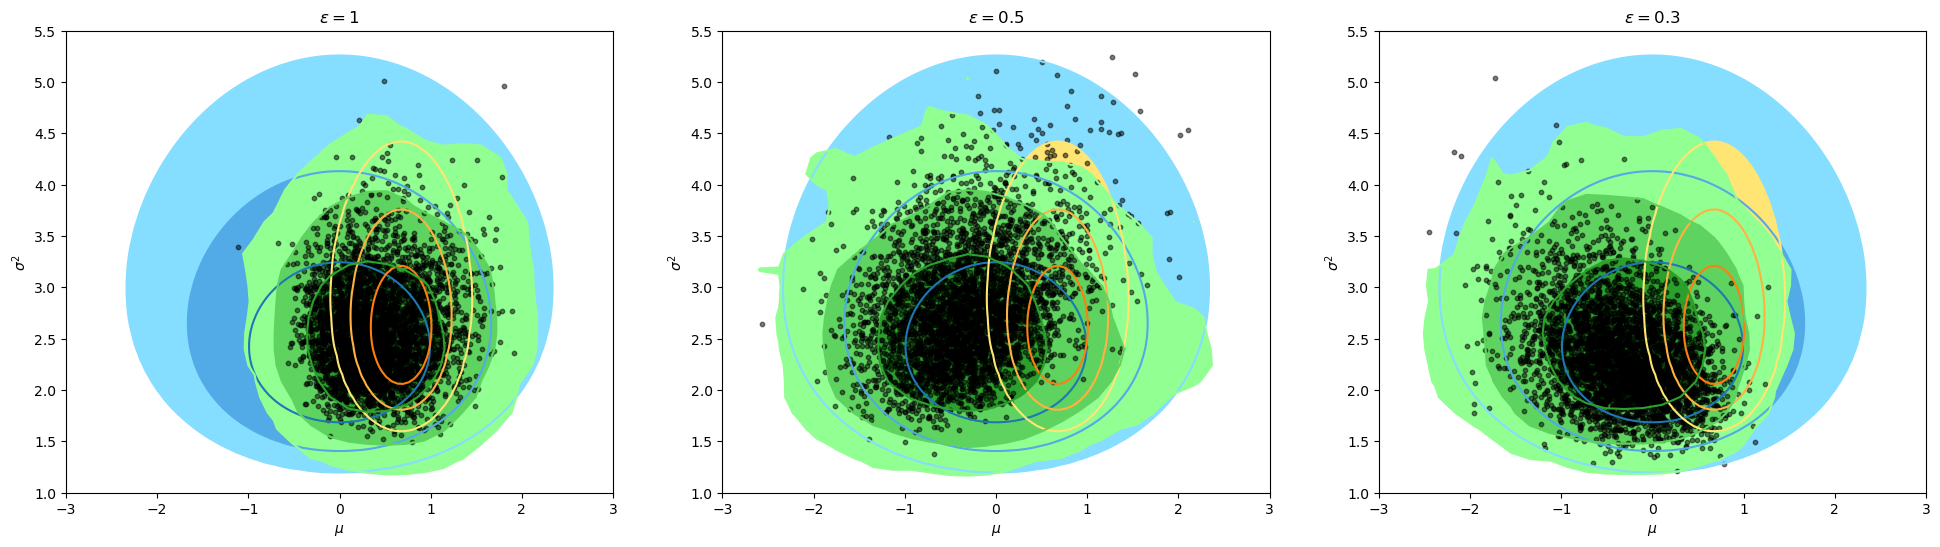

In [47]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(24,6))

ax0.set_xlim(bounds['mu'])
ax0.set_xlabel("$\mu$")
ax0.set_ylim(bounds['sigma_sq'])
ax0.set_ylabel("$\sigma^2$")
ax0.set_title(r"$\epsilon=1$")
ax0.contourf(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])
ax0.contour(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])

ax0.contourf(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
ax0.contour(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
ax0.contour(mu_g_2, sigma_sq_g_2, rejection_eps1_g, levels=rejection_eps1_contours,
                    colors=colors[2][:nContourLevels][::-1])
ax0.contourf(mu_g_2, sigma_sq_g_2, rejection_eps1_g, levels=rejection_eps1_contours,
                    colors=colors[2][:nContourLevels][::-1])
ax0.scatter(rejection_samples_eps1[:, 0], rejection_samples_eps1[:, 1], s=10, alpha=0.5, color='black')

ax1.set_xlim(bounds['mu'])
ax1.set_xlabel("$\mu$")
ax1.set_ylim(bounds['sigma_sq'])
ax1.set_ylabel("$\sigma^2$")
ax1.set_title(r"$\epsilon=0.5$")
ax1.contourf(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])
ax1.contour(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])
ax1.contourf(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
ax1.contour(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
ax1.contour(mu_g_2, sigma_sq_g_2, rejection_eps1_dropPhi1_g, levels=rejection_eps1_dropPhi1_contours,
                    colors=colors[2][:nContourLevels][::-1])
ax1.contourf(mu_g_2, sigma_sq_g_2, rejection_eps1_dropPhi1_g, levels=rejection_eps1_dropPhi1_contours,
                    colors=colors[2][:nContourLevels][::-1])

ax1.scatter(rejection_samples_eps1_dropPhi1[:, 0], rejection_samples_eps1_dropPhi1[:, 1], s=10, alpha=0.5, color='black')

ax2.set_xlim(bounds['mu'])
ax2.set_xlabel("$\mu$")
ax2.set_ylim(bounds['sigma_sq'])
ax2.set_ylabel("$\sigma^2$")
ax2.set_title(r"$\epsilon=0.3$")
ax2.contourf(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])
ax2.contour(mu_g, sigma_sq_g, prior_g, levels=prior_contours,
                    colors=colors[0][:nContourLevels][::-1])
ax2.contourf(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
ax2.contour(mu_g, sigma_sq_g, posterior_g, levels=posterior_contours,
                    colors=colors[1][:nContourLevels][::-1])
ax2.contour(mu_g_2, sigma_sq_g_2, rejection_eps1_dropPhi2_g, levels=rejection_eps1_dropPhi2_contours,
                    colors=colors[2][:nContourLevels][::-1])
ax2.contourf(mu_g_2, sigma_sq_g_2, rejection_eps1_dropPhi2_g, levels=rejection_eps1_dropPhi2_contours,
                    colors=colors[2][:nContourLevels][::-1])
ax2.scatter(rejection_samples_eps1_dropPhi2[:, 0], rejection_samples_eps1_dropPhi2[:, 1], s=10, alpha=0.5, color='black')

In [40]:
def rotator(Phi1, Phi2, angle):
    return np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]]).dot([Phi1,Phi2])

In [41]:
rotator(Phi_obs[0], Phi_obs[1], np.pi/4)

array([2.5020891 , 1.43216615])

In [42]:
Phi_obs[0], Phi_obs[1]

(0.7565497795209837, 2.78193856644805)

In [44]:
def approximate_bayesian_computation_rotator(Phi_obs, epsilon, nsamples, N, eta, lambda_, alpha, beta, drop=False):
    from math import sqrt
    accepted_samples = []
    distances = []

    # Loop over the number of simulations.
    while(len(accepted_samples) < nsamples):
        # --- Sample candidate parameters from the prior ---
        sigma_sq_candidate = ss.invgamma(alpha, 0, scale=beta).rvs()
        mu_candidate = ss.norm(eta, sqrt(sigma_sq_candidate/lambda_)).rvs()

        # --- Simulation Step ---
        # We simulate one dataset for the current candidate.
        # simulator expects array inputs; here we create arrays of length 1.
        sim_data = simulator(np.array([mu_candidate]),
                             np.array([sigma_sq_candidate]),
                             N)

        # --- Compression Step ---
        # Compute the summary statistics of the simulation.
        Phi_sim = compressor(sim_data)[:, 0]  # compressor returns an array with shape (2, 1)

        # --- Rotate the summary statistics ---
        Phi_sim = rotator(Phi_sim[0], Phi_sim[1], np.pi/4)

        # --- Drop some part of the information ---
        if drop==1:
            Phitilde_sim = Phi_sim[0]
            Phitilde_obs = Phi_obs[0]
        elif drop==0:
            Phitilde_sim = Phi_sim[1]
            Phitilde_obs = Phi_obs[1]

        # --- Distance Calculation ---
        # Compute Euclidean distance between simulated and observed summaries.
        distance = np.linalg.norm(Phitilde_sim - Phitilde_obs)

        # --- Acceptance Step ---
        if distance < epsilon:
            accepted_samples.append([mu_candidate, sigma_sq_candidate])
            distances.append(distance)

    return np.array(accepted_samples), distances

In [45]:
epsilon = 1.
rejection_samples_eps1_dropPhi1, _ = approximate_bayesian_computation_rotator(Phi_obs, epsilon, 4000, N, eta, lambda_, alpha, beta, drop=0)
rejection_samples_eps1_dropPhi2, _ = approximate_bayesian_computation_rotator(Phi_obs, epsilon, 4000, N, eta, lambda_, alpha, beta, drop=1)